Car detection

In [1]:
import sys
import torch

In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [59]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [62]:
ds = ds_train.take(1)  # Only take a single example



[[<tf.Tensor: shape=(), dtype=float32, numpy=53.760002>,
  <tf.Tensor: shape=(), dtype=float32, numpy=35.84>,
  <tf.Tensor: shape=(), dtype=float32, numpy=436.48>,
  <tf.Tensor: shape=(), dtype=float32, numpy=606.72003>]]

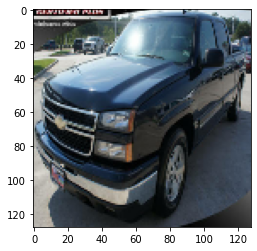

In [200]:
BATCH_SIZE = 1
NUM_BOXES = 1
IMAGE_HEIGHT = 480, 640
IMAGE_WIDTH = 640
CHANNELS = 3
CROP_SIZE = (128, 128)
image = np.reshape(image,(1,375, 500, 3))
i = example["bbox"]

boxes = [[i[0]*480,i[1]*640,i[2]*480,i[3]*640]]
box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
maxval=BATCH_SIZE, dtype=tf.int32)
output = tf.image.crop_and_resize(image/255, [[0.112 ,     0.056,      0.90933335 ,0.948     ]],[0],CROP_SIZE)
plt.imshow(output[0])
boxes

In [27]:
def normalize_img(example):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(example["image"], tf.float32) / 255., example["label"]

CROP_SIZE = (150, 150)
def preprocess_img(i):
  return tf.image.crop_and_resize(tf.cast(tf.expand_dims(i["image"],0), tf.float32) / 255.,
                                  tf.expand_dims(i["bbox"],0),[0],CROP_SIZE)[0,:,:,:], i["label"]



ds_train = ds_train.map(
    preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [28]:
ds_test = ds_test.map(
    preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [29]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(150,
                                  150,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [22]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(150, 175, 3)),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(196)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 150, 175, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 175, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 150, 175, 64)      4864      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 87, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 75, 87, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 87, 64)        36928     
                                                      

In [23]:
epochs = 15
history = model.fit(
  ds_train,
  validation_data=ds_test,
  epochs=epochs
)

Epoch 1/15
64/64 [==============================] - 92s 869ms/step - loss: 5.2788 - accuracy: 0.0052 - val_loss: 5.2774 - val_accuracy: 0.0085
Epoch 2/15
64/64 [==============================] - 19s 297ms/step - loss: 5.2777 - accuracy: 0.0083 - val_loss: 5.2768 - val_accuracy: 0.0085
Epoch 3/15
64/64 [==============================] - 19s 294ms/step - loss: 5.2771 - accuracy: 0.0083 - val_loss: 5.2760 - val_accuracy: 0.0085
Epoch 4/15
64/64 [==============================] - 19s 294ms/step - loss: 5.2765 - accuracy: 0.0083 - val_loss: 5.2754 - val_accuracy: 0.0085
Epoch 5/15
64/64 [==============================] - 19s 292ms/step - loss: 5.2759 - accuracy: 0.0083 - val_loss: 5.2747 - val_accuracy: 0.0085
Epoch 6/15
64/64 [==============================] - 19s 292ms/step - loss: 5.2755 - accuracy: 0.0083 - val_loss: 5.2741 - val_accuracy: 0.0085
Epoch 7/15
64/64 [==============================] - 19s 293ms/step - loss: 5.2750 - accuracy: 0.0083 - val_loss: 5.2736 - val_accuracy: 0.0085

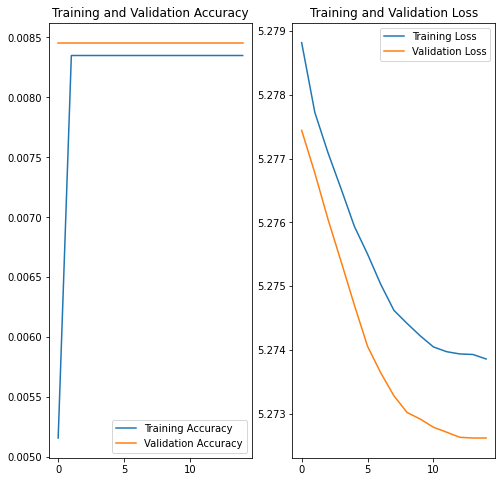

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [36]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(196)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_19 (Dropout)        (None, 2048)              0         
                                                           

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(ds_train, epochs=20, validation_data=ds_test)

Epoch 1/20
64/64 [==============================] - 36s 511ms/step - loss: 5.2786 - accuracy: 0.0056 - val_loss: 5.2768 - val_accuracy: 0.0055
Epoch 2/20
64/64 [==============================] - 32s 504ms/step - loss: 5.2773 - accuracy: 0.0063 - val_loss: 5.2759 - val_accuracy: 0.0085
Epoch 3/20
64/64 [==============================] - 31s 493ms/step - loss: 5.2765 - accuracy: 0.0083 - val_loss: 5.2751 - val_accuracy: 0.0085
Epoch 4/20
64/64 [==============================] - 32s 506ms/step - loss: 5.2761 - accuracy: 0.0083 - val_loss: 5.2746 - val_accuracy: 0.0085
Epoch 5/20
64/64 [==============================] - 32s 497ms/step - loss: 5.2754 - accuracy: 0.0083 - val_loss: 5.2741 - val_accuracy: 0.0085
Epoch 6/20
64/64 [==============================] - 32s 496ms/step - loss: 5.2750 - accuracy: 0.0083 - val_loss: 5.2736 - val_accuracy: 0.0085
Epoch 7/20
64/64 [==============================] - ETA: 0s - loss: 5.2746 - accuracy: 0.0083